# Object segmentation on OpenCL-compatible GPUs
APOC is based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [scikit-learn](https://scikit-learn.org/stable/). For object segmentation, it uses a pixel classifier and connected components labeling.

In [1]:
from skimage.io import imread, imshow, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc
from skimage.io import imshow

Let's start with loading an example image and some sparse annotation:

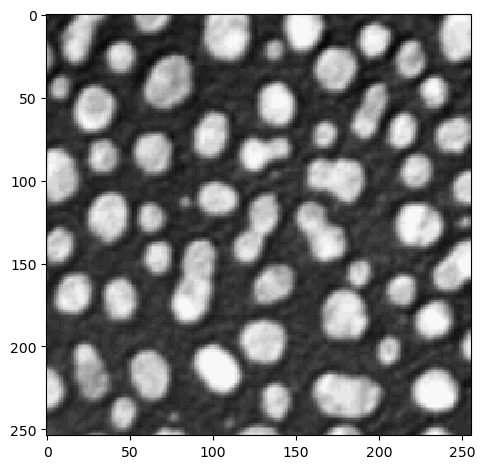

In [2]:
image = imread('../../data/blobs.tif')
imshow(image)

In [3]:
if False: # you can use this to make manual annotations
    import napari

    # start napari
    viewer = napari.Viewer()
    napari.run()

    # add image
    viewer.add_image(image)

    # add an empty labels layer and keep it in a variable
    labels = np.zeros(image.shape).astype(int)
    manual_annotations.add_labels(labels)
else:
    manual_annotations = imread('../../data/blobs_apoc_annotations.tif')

C:\Users\haase\mambaforge\envs\devbio-napari-env\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


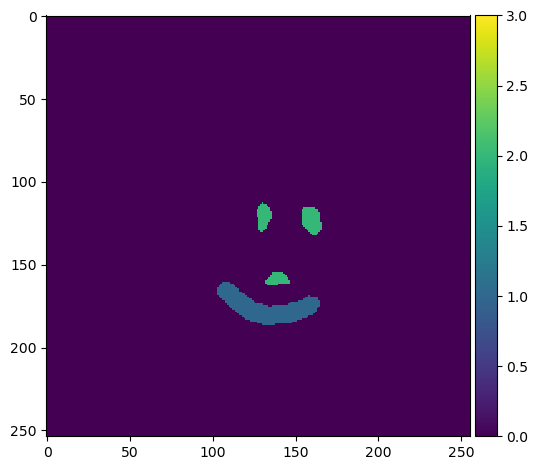

In [4]:
imshow(manual_annotations, vmin=0, vmax=3)

## Training
We now train a ObjectSegmenter, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [5]:
# define features
features = 'gaussian_blur=1 sobel_of_gaussian_blur=1'

# this is where the model will be saved
cl_filename = 'my_model.cl'

apoc.erase_classifier(cl_filename)
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, image)

## Prediction / segmentation
The classifier can then be used to classify all pixels in the given image. Starting point is again, the feature stack. Thus, the user must make sure that the same features are used for training and for prediction. Prediction can be done on the CPU using the original scikit-learn code and on the GPU using the generated OpenCL-code. OCLRFC works well if both result images look identical.

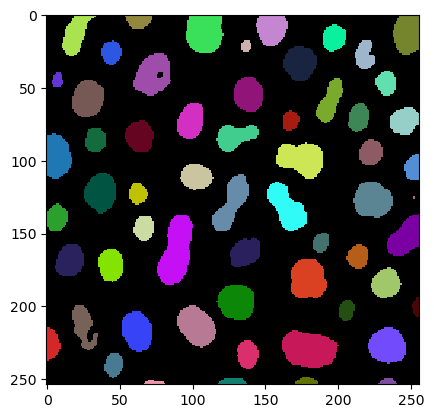

In [6]:
segmentation_result = clf.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

# Segmentation from a loaded segmenter

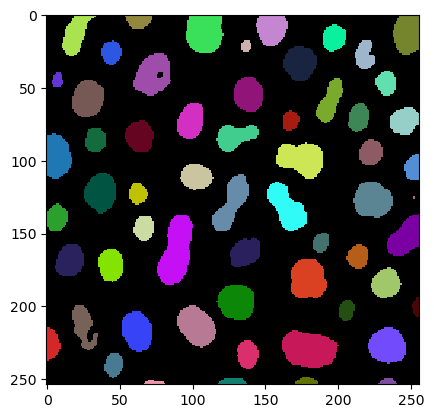

In [7]:
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename)

segmentation_result = clf.predict(image=image)
cle.imshow(segmentation_result, labels=True)

After training, we can also explore a bit how important the specified features were when making the pixel classification.

In [8]:
clf.feature_importances()

{'gaussian_blur=1': 0.7699547389372277,
 'sobel_of_gaussian_blur=1': 0.23004526106277245}

## Exercise
Also include the `original` image in the features specified above and train the model again. How does feature importance change. Why?